# Solar system simulator

Below is an example of coding up a solar system simulator in the R programming language. It can be initialised with any number of solar system bodies. To evolve the system four different numerical ODE solvers are implemented:

 * the [forward Euler](https://en.wikipedia.org/wiki/Euler_method) method (using `"Euler"` for the `method` argument)
 * the [semi-implicit Euler](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method) method, aka the [Euler-Cromer](https://aapt.scitation.org/doi/10.1119/1.12478) method (using `"EulerCromer"` for the `method` argument)
 * the [velocity Verlet](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet) method (using `"Verlet"` for the `method` argument)
 * the [Euler-Richardson](http://www.physics.udel.edu/~bnikolic/teaching/phys660/numerical_ode/node4.html) method (using `"EulerRichardson"` for the `method` argument)
 * a 4th order [Runge-Kutta](https://www.compadre.org/PICUP/resources/Numerical-Integration/) method (using `"RungeKutta"` for the `method` argument)

This has been created within a Jupyter notebook within a Conda environment set up as follows:

```bash
conda create -n solsym python=3.8
conda activate solsym
conda install jupyter
conda install r-irkernel
conda install r-ggplot2
```

In [2]:
library(ggplot2)

#' Calculate the Euclidean vector norm
#'
#' @param x A vector
#' @return norm The Euclidean norm of the vector
norm <- function(x) {
    sqrt(sum(x^2))
}
    
#' Compute the mutual gravitational accelerations of a set of massive bodies.
#'
#' @param pos A matrix of 3D positions for each object (m)
#' @param masses A vector of masses for each object (kg)
#' @return derivs A matrix containing 3D accelerations for each object
grav <- function(pos, masses) {
    # Newton's gravitational constant
    G <- 6.67430e-11
    
    # number of bodies
    N <- length(masses)
    
    # initialise accelerations matrix
    acc <- matrix(0, N, 3)

    # 3D orbits
    for (i in 1:N) {
        # calculate accelerations
        for (j in 1:N){
            if (i != j) {
                # distance between objects
                diff <- pos[i,] - pos[j,]
                r <- norm(diff)

                # dv/dt = a  (a = F/m) (F = GMm|x2-x1|/r^3)
                acc[j,] <- acc[j,] + G * masses[i] * diff / r^3
            }
        }
    }

    return(acc)
}

#' Evolve a system of gravitationally interacting bodies by one time step using
#' a given numerical ODE solver method.
#'
#' @param pos A matrix of initial positions for each body (m)
#' @param vel A matrix of initial velocities for each body (m/s)
#' @param masses A vector of masses for each body (kg)
#' @param dt The time step to increment by (s)
#' @param method A string giving the method used to evolve the positions/velocities
#' @return A list containing two matrices with the updated positions and velocities
evolve <- function(pos, vel, masses, dt, method) {
    # calculate the current acceleration
    acc <- grav(pos, masses)

    if ( method == "Euler" ) {
        # use the foward Euler method 
        newpos <- pos + vel * dt
        newvel <- vel + acc * dt
    }
    else if ( method == "EulerCromer" ) {
        # use the semi-implicit Euler aka Euler-Cromer method
        newvel <- vel + acc * dt
        newpos <- pos + newvel * dt
    }
    else if ( method == "Verlet" ) {
        # use the velocity Verlet method
        
        # get new position using Euler
        intpos <- pos + vel * dt
        
        # get current and next acceleration
        curacc <- grav(pos, masses)
        newacc <- grav(intpos, masses)
        
        newpos <- pos + vel * dt + 0.5 * curacc * dt^2
        newvel <- vel + 0.5 * (curacc + newacc) * dt
    }
    else if ( method == "EulerRichardson" ) {
        # use the Euler-Richardson method
        
        # get positions and velocities at mid-point using Euler
        midpos <- pos + 0.5 * vel * dt
        midvel <- vel + 0.5 * acc * dt
        
        # get acceleration at mid-point
        midacc <- grav(midpos, masses)
        
        # get final position and velocity using mid-point values
        newpos <- pos + midvel * dt
        newvel <- vel + midacc * dt
    }
    else if ( method == "RungeKutta" ) {
        # use a 4th order Runge-Kutta method
        k1v <- acc * dt
        k1x <- vel * dt
        
        k2v <- grav(pos + 0.5 * k1x, masses) * dt
        k2x <- (vel + 0.5 * k1v) * dt
        
        k3v <- grav(pos + 0.5 * k2x, masses) * dt
        k3x <- (vel + 0.5 * k2v) * dt
        
        k4v <- grav(pos + k3x, masses) * dt
        k4x <- (vel + k3v) * dt
        
        newpos <- pos + (1/6)*(k1x + 2 * (k2x + k3x) + k4x)
        newvel <- vel + (1/6)*(k1v + 2 * (k2v + k3v) + k4v)
    }
    else {
        stop("Unknown method given")
    }

    return(list(newpos, newvel))
}

#' Run an n-body gravitationally interacting simulation over time
#'
#' @param pos A matrix of initial positions of the bodies (m)
#' @param vel A matrix of initial velocites of the bodies (m/s)
#' @param masses A vector of the masses of the bodies (kg)
#' @param dt The time step for each iteration of the simulation (s)
#' @param T The total time over which to run the simulation (s)
#' @param method The numerical method for evolving the simulation
#' @param The names of the objects (for creating a dataframe)
#' @return A dataframe with positions and velocities
run <- function(pos, vel, masses, dt, T, method, names) {
    # number of iterations required for simulation
    Niterations <- floor(T / dt)

    Nbodies <- length(masses)

    # create output arrays
    positions <- array(0, dim=c(Niterations+1, Nbodies, 3))
    velocities <- array(0, dim=c(Niterations+1, Nbodies, 3))

    # put in initial values
    positions[1,,] <- pos
    velocities[1,,] <- vel

    # evolve the system
    for ( i in 1:Niterations ){
        posvel <- evolve(positions[i,,], velocities[i,,], masses, dt, method)

        # store new values
        positions[i+1,,] <- posvel[[1]]
        velocities[i+1,,] <- posvel[[2]]
    }

    # convert to data frame
    df <- data.frame(x=c(), y=c(), z=c(), vx=c(), vy=c(), vz=c(), planet=c())
    for ( i in 1:Nbodies ){
        df <- rbind(df, data.frame(x=positions[,i,1], y=positions[,i,2], z=positions[,i,3], vx=velocities[,i,1], vy=velocities[,i,2],vx=velocities[,i,3], planet=names[i]))
    }
    return(df)
}

Run a simulation of a system consisting of the Sun, Earth and Jupyter for a period of 10 years using a time step of 10000 seconds. The initial positions and velocities for the bodies are taken from the [JPL Horizons](https://ssd.jpl.nasa.gov/horizons.cgi) ephemeris using an initial date of 2021-Mar-10 00:00:00.0 TDB. The positions and velocities are 3D values within a system centred on the solar system barycentre and must be converted from km and km/s to m and m/s. The masses given are also those provided by JPL Horizons.

In [3]:
G <- 6.67430e-11

# set Sun, Earth and Jupiter masses
masses = c(1988500e24, 5.97219e24, 1898.13e24)
Nbodies <- length(masses)

# set initial positions (from JPL Horizons at 2021-Mar-10 00:00:00.0000 TDB) converted from km to m
pos <- matrix(0, Nbodies, 3)
pos[1,] <- c(-1.062200030114858e06, 8.362371682321193e05, 1.795712568200991e04) * 1000
pos[2,] <- c(-1.470645054608552e08, 2.830272167522374e07, 1.741926991295628e04) * 1000
pos[3,] <- c(5.121969780870578e08, -5.581619605983400e08, -9.143644350812107e06) * 1000

# set initial velocities - converted from km/s to m/s
vel <- matrix(0, Nbodies, 3)
vel[1,] <- c(-1.099638022537344e-02, -1.109711568567712e-02, 3.554866815339117e-04) * 1000
vel[2,] <- c(-6.013315897056111e00, -2.940583082165495e01, 2.431935395957652e-03) * 1000
vel[3,] <- c(9.467129834062035e00, 9.450926468036958e00, -2.509855347520396e-01) * 1000

# run simulation for 10 years
dt = 10000  # time step
T = 365 * 10 * 86400  # total time
method = "RungeKutta"
names = c("Sun", "Earth", "Jupiter")
sim <- run(pos, vel, masses, dt, T, method, names)

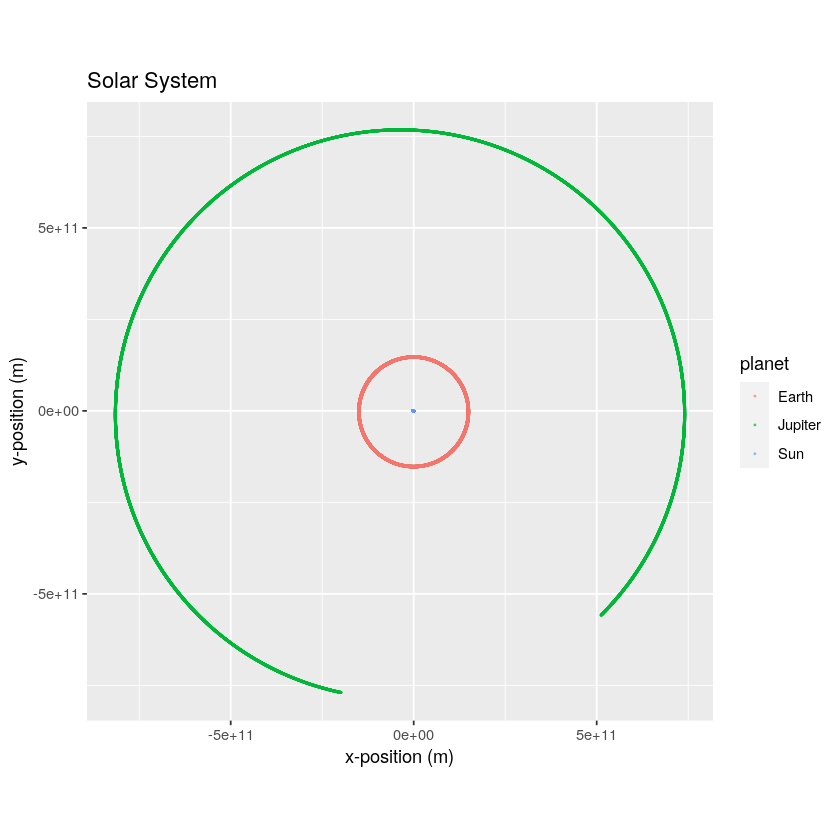

In [4]:
# make a plot of orbits
p <- ggplot(data=sim, aes(x, y, z)) + geom_point(alpha=0.5, aes(color=planet), size=0.2)

# set equal axis ratio
p <- p + coord_fixed(ratio = 1) + labs(x="x-position (m)", y="y-position (m)", title="Solar System")
print(p)